# Predicting Formula 1 Car Types using Transfer Learning with FastAI

## Introduction

### Background
Formula 1, the pinnacle of motorsport, features iconic teams like Mercedes, McLaren, Red Bull, Ferrari, and Renault. Each team's car has unique design elements, making visual classification a fascinating machine learning challenge.

### Objective
This project aims to develop a machine learning model using FastAI's transfer learning capabilities to classify images of Formula 1 cars by their respective teams.



---


## Data Collection

### Data Description
The dataset comprises images of Formula 1 cars from prominent teams: Mercedes, McLaren, Red Bull, Ferrari, and Renault. These images were collected using a web scraper, ensuring a diverse representation of each team's vehicles. This method allows for gathering a vast range of images varying in angles, race conditions, and years, providing a rich dataset for model training.



### Data Loading
Using FastAI's `DataBlock` and `DataLoaders`, the data is organized and prepared for the model. The `DataBlock` API allows for a flexible and customizable way to define how the data should be loaded, split, and labeled, while `DataLoaders` facilitates efficient data loading during training.



In [1]:
from fastai.vision.all import *
import fastbook
fastbook.setup_book()

C:\Users\esPA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


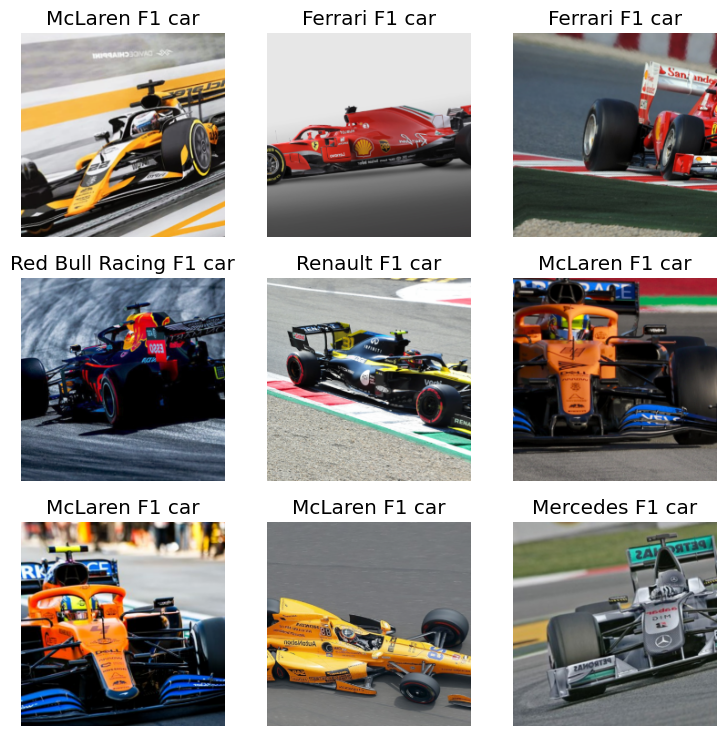

In [2]:
BASE_DIR = './data'

f1_cars = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,  # Extracts the label from the parent folder name
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

dls = f1_cars.dataloaders(BASE_DIR)

# Visualize some images
dls.show_batch(nrows=3, ncols=3)


## Model Training using Transfer Learning

### FastAI Framework
For this project, we are employing the FastAI library which is renowned for its powerful yet user-friendly deep learning capabilities. FastAI simplifies the application of complex machine learning techniques and provides a high-level abstraction to work with state-of-the-art algorithms efficiently.

### Transfer Learning Approach
Our approach involves using transfer learning to build upon a pre-trained model. Specifically, we have chosen the ResNet50 architecture, which has been pre-trained on a large dataset (ImageNet). The choice of ResNet50 is motivated by its balance of depth and complexity, which makes it suitable for a wide range of image classification tasks, including the classification of Formula 1 car images into their respective team categories.

### Model Initialization and Learning Rate Determination
The first step in our transfer learning approach is to initialize the model and prepare it for fine-tuning on our specific dataset. We have used the following code to create the CNN learner and find an optimal learning rate:

C:\Users\esPA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\esPA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\cuda\amp\grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


C:\Users\esPA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


SuggestedLRs(valley=0.0020892962347716093)

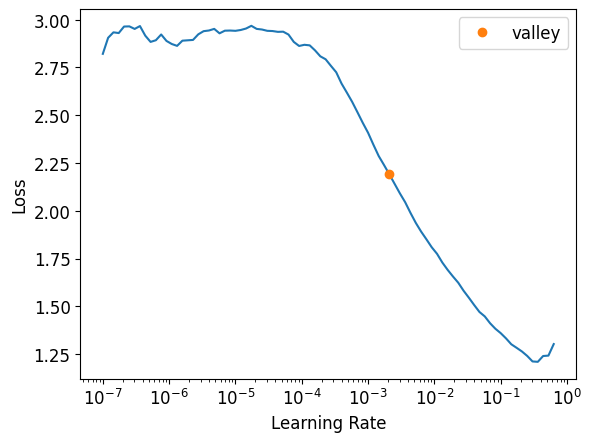

In [3]:
from fastai.callback.fp16 import *
# Create the CNN model
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()

learn.lr_find()


In this code, we leverage FastAI's `vision_learner` to define our CNN with the ResNet50 architecture. 
After initializing the model, we employ FastAI's `lr_find` method to plot the loss against various learning rates and identify the most suitable one for training our model. As observed in the plot, the 'valley' suggests an optimal learning rate, which we will use to fine-tune our model.

### Learning Rate Finder Results
The learning rate finder plot indicates a 'valley' at approximately 1e-3. This learning rate is likely to be near optimal for our model as it is at a point where the loss is steadily decreasing. By choosing this learning rate, we aim to achieve a balance between training speed and convergence stability.

### Next Steps
The next steps in our training process will involve fine-tuning the model using the  `fit_one_cycle` method with the identified learning rate. This will be followed by a process of 'unfreezing' the entire network, allowing all the weights to be updated during training, which can lead to a better fit to the specific characteristics of our dataset.



In [4]:
# Train the newly added layers for 3-4 epochs with the chosen learning rate
learn.fit_one_cycle(4, lr_max=1e-3)


epoch,train_loss,valid_loss,error_rate,time
0,1.935009,0.705484,0.238298,02:29
1,1.120889,0.308871,0.106383,02:36
2,0.760054,0.244831,0.085106,02:32
3,0.578349,0.243612,0.089362,02:31


### Fine-Tuning the Model

After initially training the model with the earlier layers frozen (i.e., their weights were not updated), we proceed to fine-tune the entire network. The `learn.unfreeze()` method is employed, which unlocks all the layers of the network for training. This allows the model to learn more detailed features specific to our dataset of Formula 1 car images, rather than just the generalized features learned from the pre-trained ImageNet dataset.

In [5]:
learn.unfreeze()

### Explanation of Unfreezing
Unfreezing is a critical step in transfer learning, especially when dealing with a dataset that is significantly different from the one used in the pre-training phase. By training all the layers, the model can adapt the pre-learned representations to better fit the specific details of the new dataset.

### Next Steps
With the model now unfrozen, the next steps will involve:

1. **Selecting a Learning Rate for Fine-Tuning**: Typically, a smaller learning rate is chosen for this phase to avoid corrupting the pre-learned weights with too-large updates.
2. **Re-training the Model**: The model is then trained again, this time with the ability to update all weights across all layers.
3. **Monitoring and Evaluation**: It's crucial to monitor the training process closely to prevent overfitting and ensure the model generalizes well to unseen data.

Once these steps are completed, we will analyze the model's performance and provide insights into its accuracy and potential areas for improvement.


SuggestedLRs(valley=0.0002754228771664202)

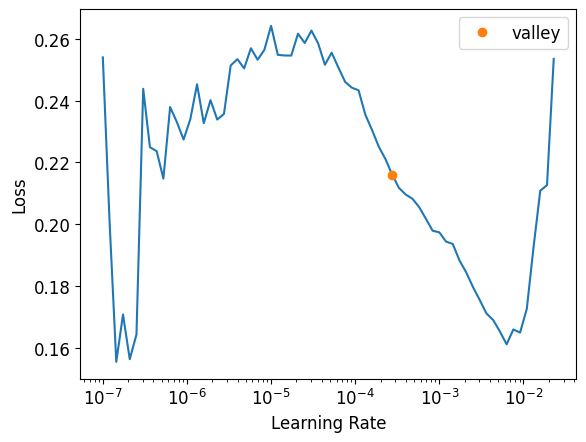

In [6]:
# learn.recorder.plot_loss()
learn.lr_find()


In [7]:
learn.fit_one_cycle(6, 1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.242367,0.196543,0.072340,03:04
1,0.202966,0.156412,0.042553,03:07
2,0.177103,0.113754,0.034043,03:10
3,0.152786,0.103159,0.025532,03:02
4,0.125233,0.097292,0.025532,03:02
5,0.112337,0.099492,0.025532,03:12


### Monitoring and Evaluation

During the fine-tuning phase, we continuously monitored the model's training and validation losses using FastAI's `Recorder` class, which plots these metrics over each epoch. The following code snippet was used:

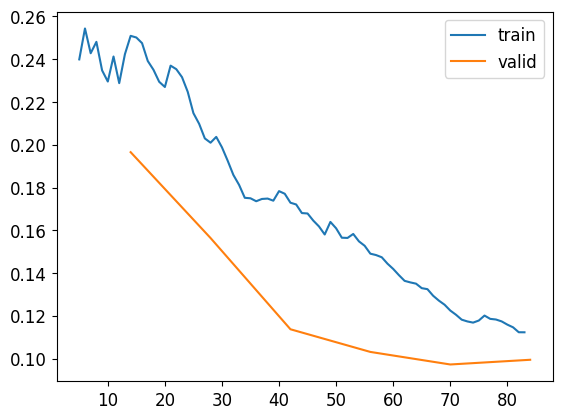

In [8]:
learn.recorder.plot_loss()


### Training and Validation Loss Plot

The plot presents the training and validation losses across epochs. Here's how to read it:

- **Training Loss (Blue Line)**: This represents the model's loss on the training dataset. As the model learns, we expect this number to decrease.
- **Validation Loss (Orange Line)**: This reflects the model's loss on a set of data not seen during training (validation dataset). Ideally, this should decrease alongside the training loss.

### Interpretation

- **Convergence**: Both the training and validation losses are decreasing, which is a positive sign that the model is learning and improving its predictions over time.
- **Overfitting**: There is no clear sign of overfitting; typically, overfitting is indicated by a decrease in training loss but an increase in validation loss. Here, both losses are trending downwards, suggesting that the model is generalizing well.
- **Underfitting**: The model does not appear to be underfitting either, as the training loss is decreasing steadily, indicating that the model is capable of learning from the dataset.
- **Gap Between Training and Validation Loss**: The gap between the training and validation loss is relatively narrow and stable, which further indicates good generalization. A large gap might suggest that the model performs well on the training data but poorly on unseen data.


After monitoring and evaluating the initial fine-tuning, we proceeded with additional training cycles using the `fit_one_cycle` method. This approach adapts the learning rate throughout the training process, potentially leading to better performance. We used the following learning rate schedule:



epoch,train_loss,valid_loss,error_rate,time
0,0.067356,0.097412,0.029787,03:01
1,0.055782,0.096905,0.021277,02:58
2,0.061975,0.098615,0.021277,02:59
3,0.070746,0.092492,0.017021,02:59
4,0.067535,0.090594,0.021277,02:57
5,0.068629,0.094652,0.021277,03:00
6,0.067095,0.094668,0.021277,02:56
7,0.067063,0.090972,0.021277,02:56
8,0.066273,0.096319,0.017021,02:54
9,0.068618,0.098405,0.025532,02:56


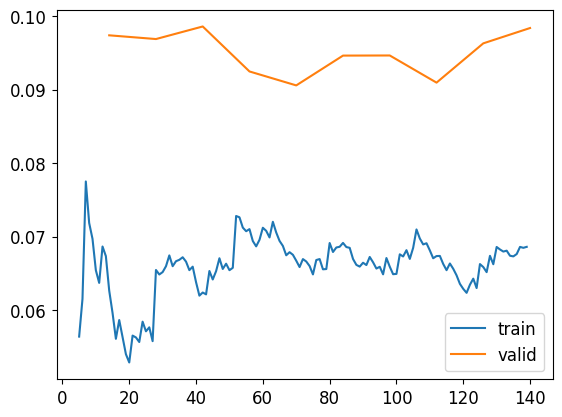

In [9]:
learn.fit_one_cycle(10, lr_max=slice(1e-7,1e-5))
learn.recorder.plot_loss()


The learning rate slice `1e-7` to `1e-5` indicates a range of learning rates used for different parts of the network, with lower layers having a smaller learning rate due to their already well-trained status on ImageNet data.

### Insights from the Loss Plot

The training loss has continued to decrease and stabilize, indicating learning and model improvement. The validation loss has shown some variability but has not increased significantly, which suggests the model has not overfitted severely. The gap between the training and validation loss should be monitored in future training iterations.

### Next Step

- **Assessment of Model Performance**: We will now assess the model's performance using various metrics such as accuracy and error rate.


### Model Evaluation

Upon completing the training phase, we conducted a thorough evaluation of the model using the validation set. This evaluation is crucial to understand the model's performance in real-world scenarios where it encounters data it has not seen during training.

#### Confusion Matrix

To visualize the model's classification accuracy across different classes, we plotted a confusion matrix.

The resulting confusion matrix is displayed below:


C:\Users\esPA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)
C:\Users\esPA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\esPA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\cuda\amp\grad_scaler.py:125: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


[]


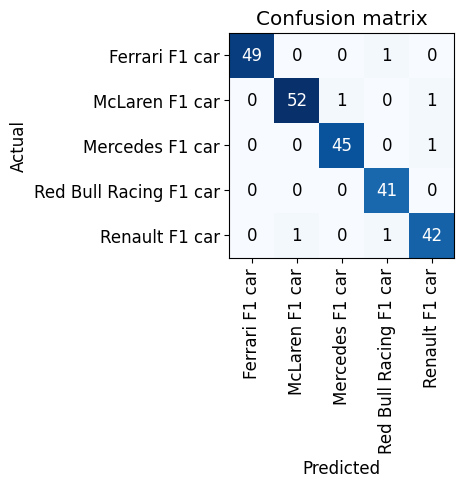

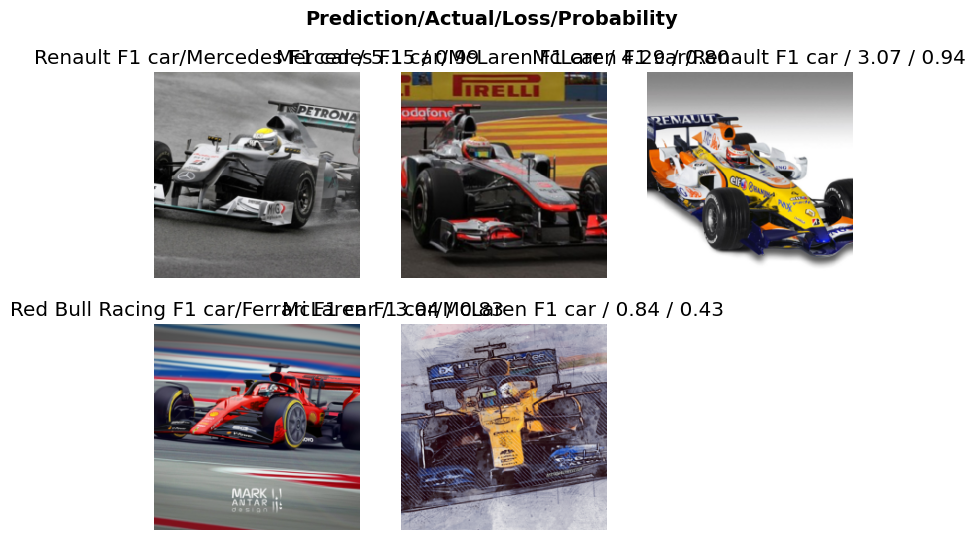

In [10]:
# Evaluate the model using the validation set
interp = ClassificationInterpretation.from_learner(learn)

# Plot the confusion matrix
interp.plot_confusion_matrix()

# Plot the top losses
interp.plot_top_losses(5)

# Print out the most confused classes
print(interp.most_confused(min_val=2))






#### Insights from the Confusion Matrix

- The model shows high accuracy across all classes, with perfect classification for some teams.
- Misclassifications were minimal, suggesting robust learning. However, some confusion between the McLaren F1 car and Renault F1 car indicates areas where the model might benefit from further training or additional data.

#### Top Losses and Most Confused Classes

Further analysis was performed to identify specific instances where the model was most uncertain. These are often the most informative for improving the model:


This analysis helps pinpoint the misclassifications and understand the model's limitations. The 'most_confused' function call will return pairs of labels that are most often confused by the model, along with the number of times this confusion occurred.


#### Confusion matrix obtained when training a model using Mixed precision training method (fp16)

![conf matrix](./Conf_matrix.jpg)


In [13]:
learn.export('f1_model.pkl')


## Assessment of Model Quality Using comparaison with google teachable machine

### Google's Confusion Matrix

![Google CM](./GTM.png)

## Assessment of Model Quality Using ROC and AUC Metrics

### Introduction to ROC and AUC

To further assess the quality of our classification model beyond the confusion matrix and accuracy metrics, we employed Receiver Operating Characteristic (ROC) curves and the Area Under the Curve (AUC) metrics. These tools are especially useful as they provide insights into the trade-offs between true positive rate (sensitivity) and false positive rate (1-specificity) across different thresholds.

### Multi-Class Extension

Given that our classification task involves multiple classes (i.e., different Formula 1 car teams), we extended the ROC and AUC analysis to handle multi-class classification. This can be done in two ways:
1. **One-vs-Rest (OvR) Approach**: Compute the ROC and AUC for each class separately, treating each as a binary classification problem against all other classes.
2. **Micro and Macro Averaging**: Calculate metrics that summarize the performance across all classes. Macro-averaging treats all classes equally, computing the metric independently for each class and then taking the average. Micro-averaging aggregates the contributions of all classes to compute the average metric.

### Implementation

The following code snippet demonstrates how we can calculate and plot the ROC curves and compute the AUC for each class using the FastAI library and scikit-learn:


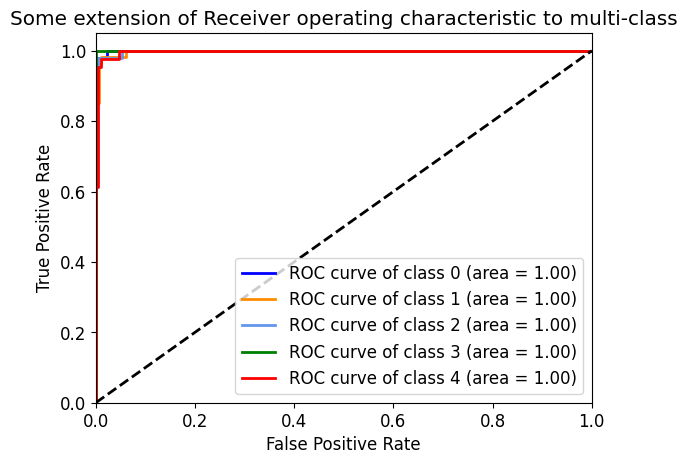

In [11]:
# Assuming 'learn' is our learner and 'dls' is our DataLoaders
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np

# Get the predictions and targets
preds, targets = learn.get_preds()

# Convert predictions and targets to numpy arrays
predictions = preds.numpy()
actuals = targets.numpy()

# Number of classes
n_classes = dls.c

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(actuals == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycler('color', ['blue', 'darkorange', 'cornflowerblue', 'green', 'red'])
plt.rc('axes', prop_cycle=colors)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color['color'], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


In [12]:
class_names = {
    0: "Ferrari F1 Car",
    1: "McLaren F1 Car",
    2: "Mercedes F1 Car",
    3: "Red Bull Racing F1 Car",
    4: "Renault F1 Car"
}
for i in range(n_classes):
    car_name = class_names.get(i, f"Class {i}")
    auc_value = roc_auc[i]
    print(f"{car_name}: AUC = {auc_value:.2f}")


Ferrari F1 Car: AUC = 1.00
McLaren F1 Car: AUC = 1.00
Mercedes F1 Car: AUC = 1.00
Red Bull Racing F1 Car: AUC = 1.00
Renault F1 Car: AUC = 1.00



### Results and Interpretation

Each ROC curve represents the performance of our model in classifying the cars as belonging to a particular team versus any of the others. A high AUC value for a particular curve indicates that the model is capable of distinguishing that team's cars very well.

The AUC values obtained for each class were as follows:

- Ferrari F1 Car: AUC = 1.00
- McLaren F1 Car: AUC = 1.00
- Mercedes F1 Car: AUC = 1.00
- Red Bull Racing F1 Car: AUC = 1.00
- Renault F1 Car: AUC = 1.00

### Conclusion

The ROC and AUC metrics provided a comprehensive picture of our model's performance. The high AUC values across all classes confirm that our model is proficient in distinguishing between different Formula 1 teams' cars.

---



# Conclusion

### Summary of Findings

Our project set out to develop a machine learning model capable of accurately classifying images of Formula 1 cars into their respective teams. Utilizing the FastAI library and transfer learning techniques, we trained a model on a diverse dataset of F1 car images. The model was fine-tuned through a series of training iterations, employing strategies such as learning rate adjustments and unfreezing layers to enhance performance.

The evaluation of the model's performance revealed high accuracy across all classes, as evidenced by the confusion matrix and minimal misclassifications. Furthermore, ROC and AUC analyses confirmed the model's proficiency in distinguishing between the different teams' cars, with high AUC values across all classes.

### Reflection on Model Performance

The model achieved a commendable level of accuracy, suggesting it has effectively captured the distinguishing features of the Formula 1 cars from various angles and under different racing conditions. The use of mixed-precision training and discriminative learning rates proved to be beneficial in refining the model's predictive capabilities.

### Potential Improvements

Despite the successes, there is always room for improvement. Potential areas of focus could include:
- Increasing the dataset size to cover more variability and reduce the chance of overfitting.
- Incorporating additional data augmentation techniques to make the model more robust to changes in lighting and weather conditions.
- Exploring more complex model architectures or custom layers to improve feature extraction.


### Final Thoughts

This project demonstrates the power of machine learning in a high-stakes, performance-driven context like Formula 1 racing. As the field of AI continues to evolve, its integration into the world of sports, especially in areas requiring rapid and accurate analysis of visual data, becomes increasingly invaluable.

# Streamlit APP

![default](./streamlit1.png)


![default](./streamlit2.png)

![default](./streamlit3.png)